# Bachelor project
The aim of this work is to train convolutional neural network (CNN)  model, that will be capable to identify glaucomatous fundus images with high accuracy and to implement a user-friendly interface for working with this model. This will be tackled via the following objectives:
- Propose and implement preprocessing and augmentation for colorful fundus images.
- Design and implement multiple convolutional neural network (CNN) models, compare their performance, and choose the best model.
- Develop and implement a user-friendly interface to easily interact with the model.

## Preprocessing

### Combine all datasets

In [1]:
import os
import shutil

# New folders
output_dir = "data/combined"
os.makedirs(os.path.join(output_dir, "healthy"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "glaucoma"), exist_ok=True)

# Images from other datasets
dataset_paths = {
    "healthy": [
        "data/datasets/Drishti/NORMAL",
        "data/datasets/LAG_database/LAG_database_part_1 2/non_glaucoma/image",
    ],
    "glaucoma": [
        "data/datasets/Drishti/GLAUCOMA",
        "data/datasets/LAG_database/LAG_database_part_1 2/suspicious_glaucoma/image",
    ],
}

# Copying files from specified paths
for category, paths in dataset_paths.items():
    for path in paths:
        if os.path.exists(path):
            for img_name in os.listdir(path):
                src_path = os.path.join(path, img_name)
                dst_path = os.path.join(output_dir, category, img_name)
                shutil.copy(src_path, dst_path)

# Process RIM-ONE dataset
rimone_path = "data/datasets/RIM-ONE"

if os.path.exists(rimone_path):
    for img_name in os.listdir(rimone_path):
        src_path = os.path.join(rimone_path, img_name)
        # Check if file name starts with 'S' or 'G' for glaucoma, or 'N' for healthy
        if img_name.startswith("S") or img_name.startswith("G"):
            dst_path = os.path.join(output_dir, "glaucoma", img_name)
            shutil.copy(src_path, dst_path)
        elif img_name.startswith("N"):
            dst_path = os.path.join(output_dir, "healthy", img_name)
            shutil.copy(src_path, dst_path)

print("Files successfully combined!")


Files successfully combined!


Check how many images of each class we have.

In [4]:
import os

glaucoma_path = "data/combined/glaucoma"
healthy_path = "data/combined/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 1855
Healthy images: 3259


From the code above we can tell, that there is almost 2x difference between amount of glaucoma and healthy images. So we have to make an augmentation for glaucoma images, but before that we have to normalize data.

### Image normalization (No need here as it's only rescaling and doesn't help with accuracy)
1. Resize the image to a fixed size for consistency.
2. Convert image from color to grayscale to simplify the image and reduce data complexity.
3. Apply Gaussian Blur to reduce noise and smooth the image.
4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
6. Normalize the image: scale pixel values to the range [0, 1]

In [5]:
import os
import cv2
import numpy as np

# Directories containing the original images
glaucoma_src = 'data/combined/glaucoma'
healthy_src = 'data/combined/healthy'
    
# Directories where the preprocessed images will be saved
glaucoma_dest = 'data/preprocessed/glaucoma'
healthy_dest = 'data/preprocessed/healthy'
    
# Create destination directories if they don't exist
os.makedirs(glaucoma_dest, exist_ok=True)
os.makedirs(healthy_dest, exist_ok=True)

# Define the target image size (width, height)
img_size = (224, 224)

# Possible preprocessing steps:
# 1. Resize the image to a fixed size for consistency.
# 2. Convert image from color to grayscale to simplify the image and reduce data complexity. (not used, because drops accuracy)
# 3. Apply Gaussian Blur to reduce noise and smooth the image. (improves accuracy a little for bigger model, but drops significantly for smaller model)
# 4. Apply histogram equalization to improve contrast (not used, because it has to receive a grayscale image, which drops accuracy)
# 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD). (not used, because drops accuracy)
# 6. Normalize the image: scale pixel values to the range [0, 1]
def process_and_save_images(src_folder, dest_folder):
    image_files = os.listdir(src_folder)
    for file in image_files:
        src_path = os.path.join(src_folder, file)
        img = cv2.imread(src_path)
        if img is not None:
            # 1. Resize the image to a fixed size for consistency.
            img = cv2.resize(img, img_size)
            
            # 2. Convert image from color to grayscale to simplify the image and reduce data complexity.
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 3. Apply Gaussian Blur to reduce noise and smooth the image.
            # img = cv2.GaussianBlur(img, (5, 5), 0)
            
            # 4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
            # img = cv2.equalizeHist(img)
            
            # 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
            # img = cv2.medianBlur(img, 3)

            # To save the image, convert normalized image back to uint8 format (for cv2.imwrite)
            img_to_save = (img).astype(np.uint8)
            dest_path = os.path.join(dest_folder, file)
            cv2.imwrite(dest_path, img_to_save)

# Process and save images for both classes
process_and_save_images(glaucoma_src, glaucoma_dest)
process_and_save_images(healthy_src, healthy_dest)

print("Preprocessing and saving completed!")

Preprocessing and saving completed!


### Augmentation
Just vertical flip for glaucoma images.

In [6]:
import os
import cv2
import numpy as np

# Directories containing preprocessed healthy and glaucoma images
healthy_src = 'data/combined/healthy'
glaucoma_src = 'data/combined/glaucoma'

# Define destination directories for final images
dest_healthy = 'data/augmented/healthy'
dest_glaucoma = 'data/augmented/glaucoma'

# Create destination directories if they don't exist
os.makedirs(dest_healthy, exist_ok=True)
os.makedirs(dest_glaucoma, exist_ok=True)

# Process healthy images: simply copy them to the destination folder
for file in os.listdir(healthy_src):
    src_path = os.path.join(healthy_src, file)
    dst_path = os.path.join(dest_healthy, file)
    image = cv2.imread(src_path)
    if image is not None:
        cv2.imwrite(dst_path, image)

# Process glaucoma images: for each image, apply multiple augmentations and save
for file in os.listdir(glaucoma_src):
    src_path = os.path.join(glaucoma_src, file)
    image = cv2.imread(src_path)
    if image is not None:
        # Save the original image
        dst_path_orig = os.path.join(dest_glaucoma, file)
        cv2.imwrite(dst_path_orig, image)
        
        # Extract base name and extension for creating augmented file names
        base_name, ext = os.path.splitext(file)
        
        # Vertical flip
        img_vflip = cv2.flip(image, 0)
        cv2.imwrite(os.path.join(dest_glaucoma, f"{base_name}_vflip{ext}"), img_vflip)

print("Healthy images copied and glaucoma images augmented (doubled) successfully!")

Healthy images copied and glaucoma images augmented (doubled) successfully!


In [7]:
import os

glaucoma_path = "data/augmented/glaucoma"
healthy_path = "data/augmented/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 3710
Healthy images: 3259


## Model training

### Splitting into training and testing dataset

In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split

# ---------------------------------------------------
# Source directories for each class
# ---------------------------------------------------
source_glaucoma = 'data/augmented/glaucoma'
source_healthy  = 'data/augmented/healthy'

# ---------------------------------------------------
# Destination directories for train/val/test splits
# ---------------------------------------------------
dest_train_glaucoma = 'data/split/train/glaucoma'
dest_val_glaucoma   = 'data/split/val/glaucoma'
dest_test_glaucoma  = 'data/split/test/glaucoma'

dest_train_healthy  = 'data/split/train/healthy'
dest_val_healthy    = 'data/split/val/healthy'
dest_test_healthy   = 'data/split/test/healthy'

# Create all destination folders
for path in [
    dest_train_glaucoma, dest_val_glaucoma, dest_test_glaucoma,
    dest_train_healthy,  dest_val_healthy,  dest_test_healthy
]:
    os.makedirs(path, exist_ok=True)

# ---------------------------------------------------
# Gather filenames
# ---------------------------------------------------
files_glaucoma = os.listdir(source_glaucoma)
files_healthy  = os.listdir(source_healthy)

# ---------------------------------------------------
# Step 1: split off 10% for test
# ---------------------------------------------------
train_temp_gl, test_gl = train_test_split(
    files_glaucoma, test_size=0.1, random_state=42, shuffle=True
)
train_temp_he, test_he = train_test_split(
    files_healthy,  test_size=0.1, random_state=42, shuffle=True
)

# ---------------------------------------------------
# Step 2: from the remaining 90%, split 11.11%→val to get 10% of total
# (0.1 / 0.9 ≈ 0.1111)
# ---------------------------------------------------
train_gl, val_gl = train_test_split(
    train_temp_gl, test_size=0.1111, random_state=42, shuffle=True
)
train_he, val_he = train_test_split(
    train_temp_he, test_size=0.1111, random_state=42, shuffle=True
)

# ---------------------------------------------------
# Helper to copy files
# ---------------------------------------------------
def copy_files(file_list, src_dir, dst_dir):
    for fname in file_list:
        shutil.copy(
            os.path.join(src_dir, fname),
            os.path.join(dst_dir, fname)
        )

# ---------------------------------------------------
# Copy glaucoma images
# ---------------------------------------------------
copy_files(train_gl, source_glaucoma, dest_train_glaucoma)
copy_files(val_gl,   source_glaucoma, dest_val_glaucoma)
copy_files(test_gl,  source_glaucoma, dest_test_glaucoma)

# ---------------------------------------------------
# Copy healthy images
# ---------------------------------------------------
copy_files(train_he, source_healthy, dest_train_healthy)
copy_files(val_he,   source_healthy, dest_val_healthy)
copy_files(test_he,  source_healthy, dest_test_healthy)

print("Data successfully split into train (80%), val (10%), test (10%) folders!")

Data successfully split into train (80%), val (10%), test (10%) folders!


### Training

In [8]:
from tensorflow.keras.metrics import Precision, Recall, AUC

#### v1

In [20]:
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# ---------------------------------------------------
# Parameters: image dimensions, batch size, epochs
# ---------------------------------------------------
img_width, img_height = 224, 224
batch_size = 32
epochs = 30

# ---------------------------------------------------
# Data directories for train / val / test splits (80/10/10)
# ---------------------------------------------------
train_data_dir = 'data/split/train'
val_data_dir   = 'data/split/val'
test_data_dir  = 'data/split/test'

# ---------------------------------------------------
# Create ImageDataGenerators with basic preprocessing
# ---------------------------------------------------
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

# ---------------------------------------------------
# Load train, val, and test data
# ---------------------------------------------------
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],  # explicit class order
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

# ---------------------------------------------------
# Build the CNN model
# ---------------------------------------------------
model = Sequential([
    InputLayer(input_shape=(img_width, img_height, 3)),  # RGB images
    Conv2D(32, (3, 3), activation='relu'),               # Conv block 1
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),               # Conv block 2
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),              # Conv block 3
    MaxPooling2D((2, 2)),
    Flatten(),                                           # Flatten feature maps
    Dense(128, activation='relu'),                       # Fully connected
    Dropout(0.5),                                        # Regularization
    Dense(1, activation='sigmoid')                       # Binary output
])

# ---------------------------------------------------
# Compile the model
# ---------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),             # ROC-AUC
        AUC(name='prc', curve='PR')  # PR-AUC
    ]
)

# ---------------------------------------------------
# Display model summary
# ---------------------------------------------------
model.summary()

# ---------------------------------------------------
# Train the model, validating on the 10% validation split
# ---------------------------------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# ---------------------------------------------------
# Save training history to file
# ---------------------------------------------------
os.makedirs('models', exist_ok=True)
with open("models/history_v1.pkl", "wb") as f:
    pickle.dump(history.history, f)

# ---------------------------------------------------
# Final evaluation on the 10% test set
# ---------------------------------------------------
metrics = model.evaluate(test_generator, return_dict=True, verbose=1)
print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC-AUC   : {metrics['auc']:.4f}")
print(f"Test PR-AUC    : {metrics['prc']:.4f}")

# ---------------------------------------------------
# Save the trained model in Keras format
# ---------------------------------------------------
model.save("models/cnn_model_v1.keras")

Found 5575 images belonging to 2 classes.
Found 697 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 63s 351ms/step - accuracy: 0.5553 - auc: 0.5856 - loss: 0.6750 - prc: 0.6094 - precision: 0.5810 - recall: 0.5697 - val_accuracy: 0.6786 - val_auc: 0.8544 - val_loss: 0.5705 - val_prc: 0.8509 - val_precision: 0.8808 - val_recall: 0.4582
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 336ms/step - accuracy: 0.7710 - auc: 0.8495 - loss: 0.4872 - prc: 0.8508 - precision: 0.7846 - recall: 0.7738 - val_accuracy: 0.8350 - val_auc: 0.9135 - val_loss: 0.3816 - val_prc: 0.9231 - val_precision: 0.8575 - val_recall: 0.8275
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 336ms/step - accuracy: 0.8275 - auc: 0.9053 - loss: 0.3916 - prc: 0.9115 - precision: 0.8343 - recall: 0.8445 - val_accuracy: 0.8508 - val_auc: 0.9339 - val_loss: 0.3453 - val_prc: 0.9411 - val_precision: 0.8346 - val_recall: 0.8976
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 337ms/step - accuracy: 0.8466 - auc: 0.9195 - loss: 0.3644 - prc: 0.9241 - precision: 0.8463 - recall: 0.8644 - val_accuracy:

#### v2

In [2]:
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# ---------------------------------------------------
# Parameters: image dimensions, batch size, epochs
# ---------------------------------------------------
img_width, img_height = 224, 224
batch_size = 32
epochs = 30

# ---------------------------------------------------
# Data directories for train / val / test splits (80/10/10)
# ---------------------------------------------------
train_data_dir = 'data/split/train'
val_data_dir   = 'data/split/val'
test_data_dir  = 'data/split/test'

# ---------------------------------------------------
# Create ImageDataGenerators with basic preprocessing
# ---------------------------------------------------
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

# ---------------------------------------------------
# Load train, val, and test data
# ---------------------------------------------------
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

# ---------------------------------------------------
# Build the CNN model (v2)
# ---------------------------------------------------
model = Sequential([
    InputLayer(input_shape=(img_width, img_height, 3)),  # RGB images
    Conv2D(16, (3, 3), activation='relu'),               # Conv block 1
    MaxPooling2D((2, 2)),                                # Pooling 1
    Flatten(),                                           # Flatten feature maps
    Dense(32, activation='relu'),                        # Fully connected
    Dense(1, activation='sigmoid')                       # Binary output
])

# ---------------------------------------------------
# Compile the model
# ---------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),             # ROC-AUC
        AUC(name='prc', curve='PR')  # PR-AUC
    ]
)

# ---------------------------------------------------
# Display model summary
# ---------------------------------------------------
model.summary()

# ---------------------------------------------------
# Train the model, validating on the 10% validation split
# ---------------------------------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# ---------------------------------------------------
# Save training history to file
# ---------------------------------------------------
os.makedirs('models', exist_ok=True)
with open("models/history_v2.pkl", "wb") as f:
    pickle.dump(history.history, f)

# ---------------------------------------------------
# Final evaluation on the 10% test set
# ---------------------------------------------------
metrics = model.evaluate(test_generator, return_dict=True, verbose=1)
print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC-AUC   : {metrics['auc']:.4f}")
print(f"Test PR-AUC    : {metrics['prc']:.4f}")

# ---------------------------------------------------
# Save the trained model in Keras format
# ---------------------------------------------------
model.save("models/cnn_model_v2.keras")

Found 5575 images belonging to 2 classes.
Found 697 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 197136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     6,308,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,308,865 (24.07 MB)

 Trainable params: 6,308,865 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.6813 - auc: 0.7415 - loss: 0.5874 - prc: 0.7386 - precision: 0.7004 - recall: 0.7111 - val_accuracy: 0.7963 - val_auc: 0.8946 - val_loss: 0.4433 - val_prc: 0.8849 - val_precision: 0.7473 - val_recall: 0.9326
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8303 - auc: 0.9090 - loss: 0.3876 - prc: 0.9110 - precision: 0.8275 - recall: 0.8605 - val_accuracy: 0.8321 - val_auc: 0.9300 - val_loss: 0.3778 - val_prc: 0.9268 - val_precision: 0.7749 - val_recall: 0.9650
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8704 - auc: 0.9412 - loss: 0.3202 - prc: 0.9411 - precision: 0.8591 - recall: 0.9028 - val_accuracy: 0.8737 - val_auc: 0.9456 - val_loss: 0.3053 - val_prc: 0.9449 - val_precision: 0.8529 - val_recall: 0.9218
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8898 - auc: 0.9541 - loss: 0.2820 - prc: 0.9568 - precision: 0.8850 - recall: 0.9102 - val_accuracy:

#### v3

In [3]:
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# ---------------------------------------------------
# Parameters: image dimensions, batch size, epochs
# ---------------------------------------------------
img_width, img_height = 224, 224
batch_size = 32
epochs = 30

# ---------------------------------------------------
# Data directories for train / val / test splits (80/10/10)
# ---------------------------------------------------
train_data_dir = 'data/split/train'
val_data_dir   = 'data/split/val'
test_data_dir  = 'data/split/test'

# ---------------------------------------------------
# Create ImageDataGenerators with basic preprocessing
# ---------------------------------------------------
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

# ---------------------------------------------------
# Load train, val, and test data
# ---------------------------------------------------
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma'],
    shuffle=False
)

# ---------------------------------------------------
# Build the CNN model (v3)
# ---------------------------------------------------
model = Sequential([
    InputLayer(input_shape=(img_width, img_height, 3)),  # RGB images
    Conv2D(32, (3, 3), activation='relu'),               # Conv block 1
    MaxPooling2D((2, 2)),                                # Pooling 1
    Conv2D(64, (3, 3), activation='relu'),               # Conv block 2
    MaxPooling2D((2, 2)),                                # Pooling 2
    Flatten(),                                           # Flatten feature maps
    Dense(64, activation='relu'),                        # Fully connected
    Dropout(0.5),                                        # Regularization
    Dense(1, activation='sigmoid')                       # Binary output
])

# ---------------------------------------------------
# Compile the model
# ---------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),             # ROC-AUC
        AUC(name='prc', curve='PR')  # PR-AUC
    ]
)

# ---------------------------------------------------
# Display model summary
# ---------------------------------------------------
model.summary()

# ---------------------------------------------------
# Train the model, validating on the 10% validation split
# ---------------------------------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# ---------------------------------------------------
# Save training history to file
# ---------------------------------------------------
os.makedirs('models', exist_ok=True)
with open("models/history_v3.pkl", "wb") as f:
    pickle.dump(history.history, f)

# ---------------------------------------------------
# Final evaluation on the 10% test set
# ---------------------------------------------------
metrics = model.evaluate(test_generator, return_dict=True, verbose=1)
print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC-AUC   : {metrics['auc']:.4f}")
print(f"Test PR-AUC    : {metrics['prc']:.4f}")

# ---------------------------------------------------
# Save the trained model in Keras format
# ---------------------------------------------------
model.save("models/cnn_model_v3.keras")

Found 5575 images belonging to 2 classes.
Found 697 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.6160 - auc: 0.6645 - loss: 0.6420 - prc: 0.6725 - precision: 0.6281 - recall: 0.6487 - val_accuracy: 0.7747 - val_auc: 0.8555 - val_loss: 0.4961 - val_prc: 0.8519 - val_precision: 0.7801 - val_recall: 0.8032
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 272ms/step - accuracy: 0.7559 - auc: 0.8231 - loss: 0.5178 - prc: 0.8234 - precision: 0.7538 - recall: 0.8072 - val_accuracy: 0.8077 - val_auc: 0.9063 - val_loss: 0.4131 - val_prc: 0.9157 - val_precision: 0.7788 - val_recall: 0.8922
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.8027 - auc: 0.8812 - loss: 0.4396 - prc: 0.8826 - precision: 0.7928 - recall: 0.8474 - val_accuracy: 0.7905 - val_auc: 0.9301 - val_loss: 0.4211 - val_prc: 0.9368 - val_precision: 0.7255 - val_recall: 0.9757
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 271ms/step - accuracy: 0.8154 - auc: 0.8972 - loss: 0.4069 - prc: 0.9072 - precision: 0.8109 - recall: 0.8703 - val_accuracy:

## Testing

Model loaded from models/cnn_model_v3.keras
Found 697 images belonging to 2 classes.


c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step

Keras evaluate metrics:
accuracy    : 0.9340
auc         : 0.9816
loss        : 0.1684
prc         : 0.9782
precision   : 0.9428
recall      : 0.9326

Scikit-learn metrics:
accuracy : 0.9340
recall   : 0.9326
precision: 0.9428
f1_score : 0.9377

Classification report:
              precision    recall  f1-score   support

     healthy       0.92      0.94      0.93       326
    glaucoma       0.94      0.93      0.94       371

    accuracy                           0.93       697
   macro avg       0.93      0.93      0.93       697
weighted avg       0.93      0.93      0.93       697



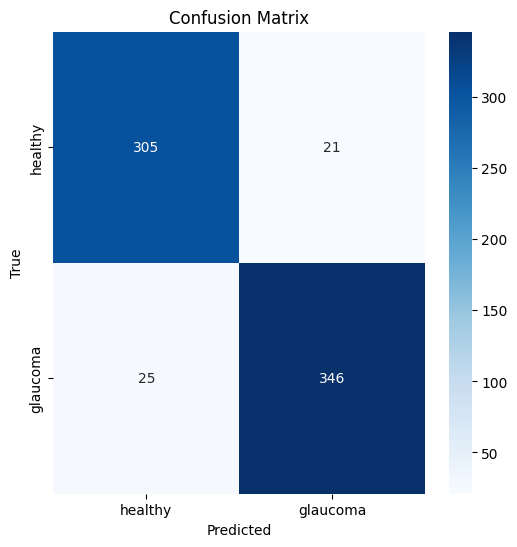

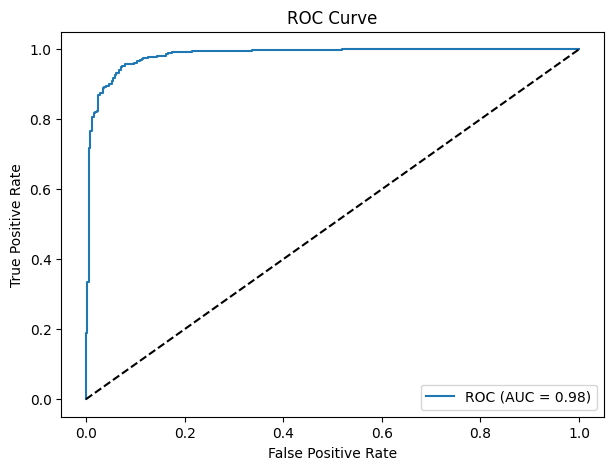

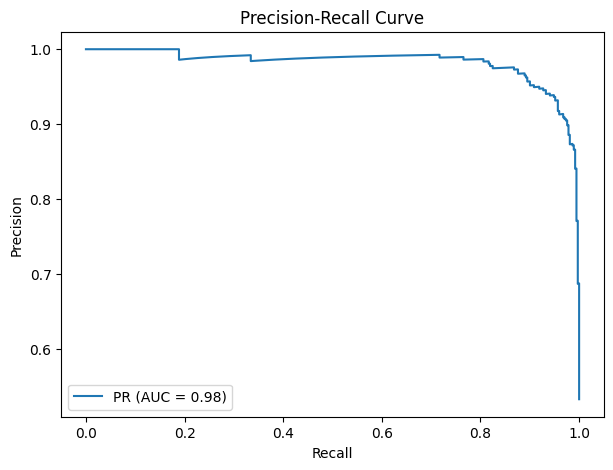

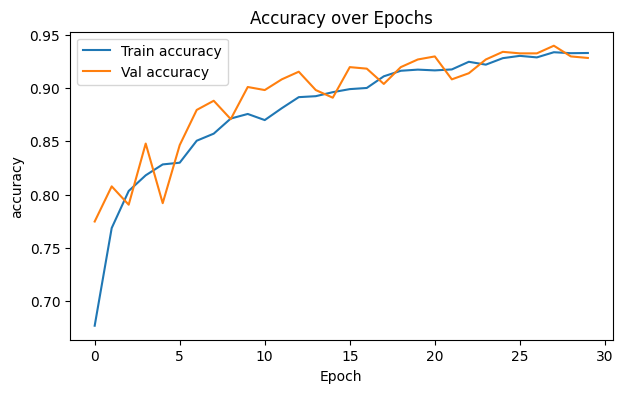

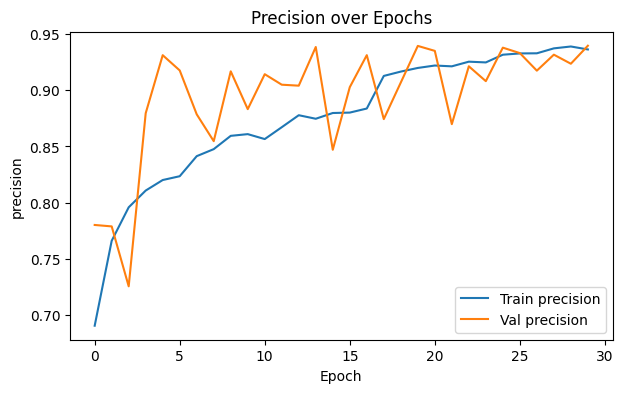

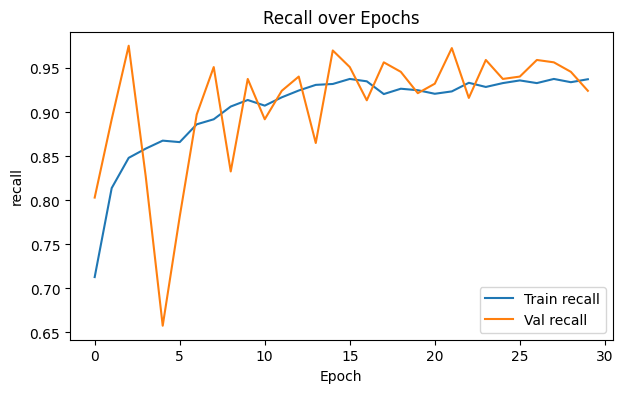

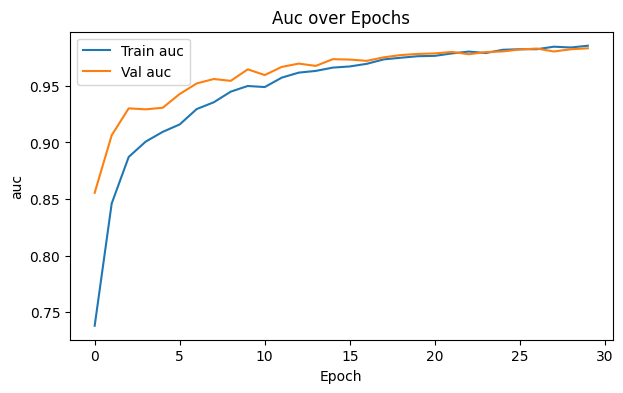

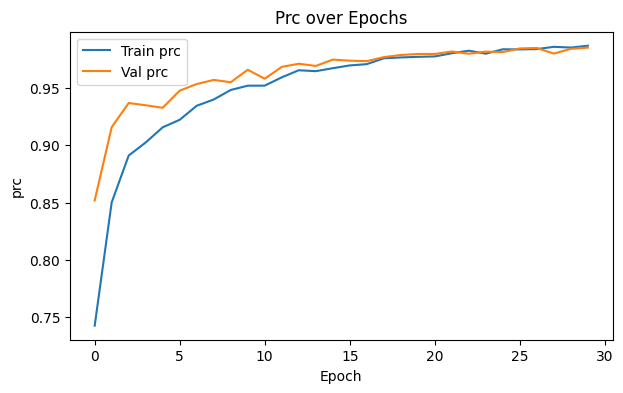

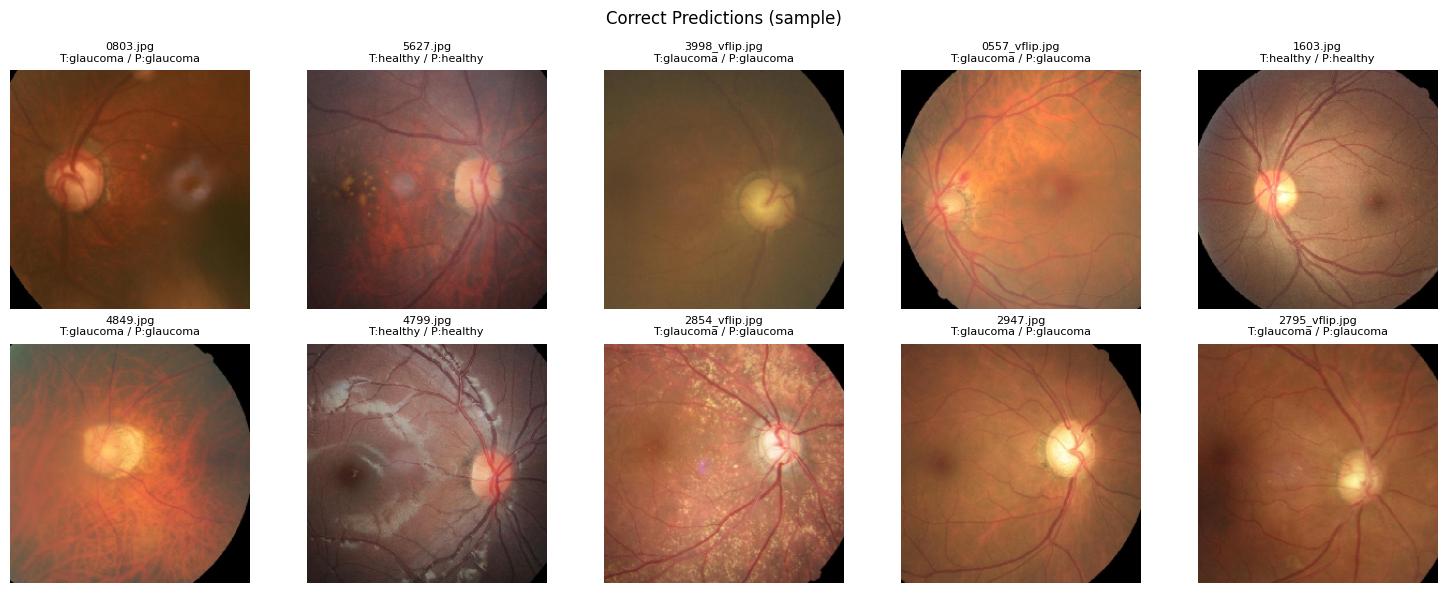

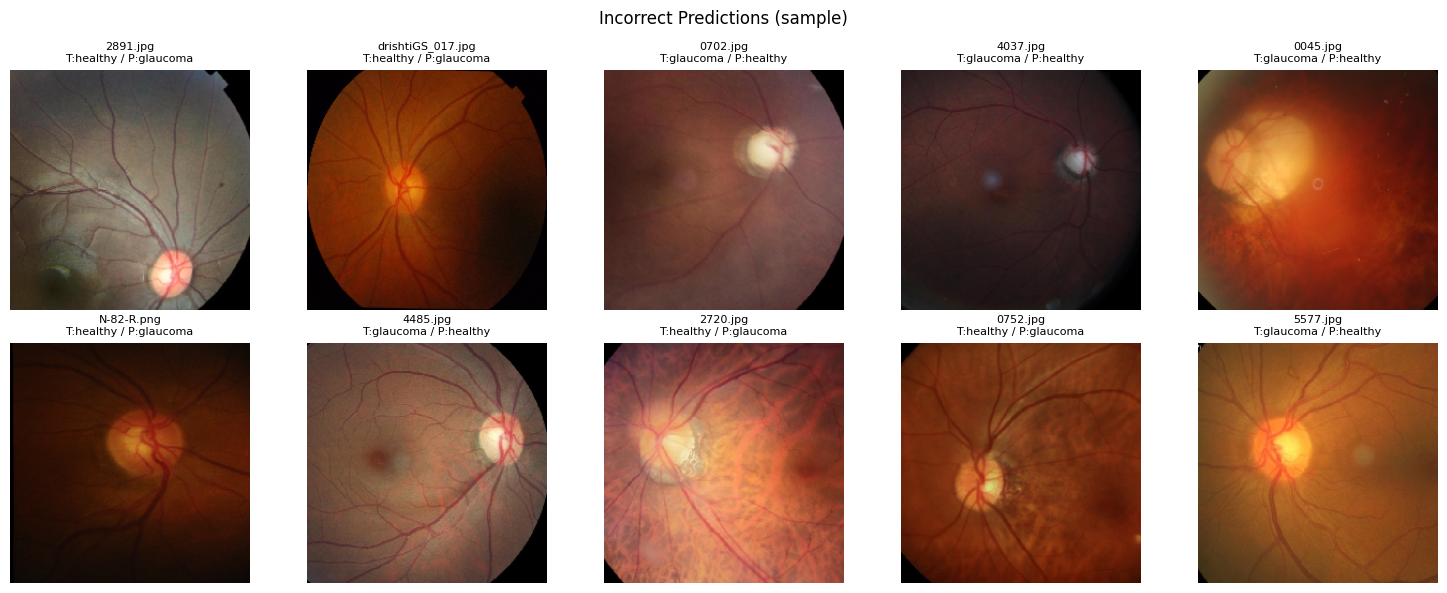


Total correct   : 651
Total incorrect : 46


In [7]:
import os
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve
)

# ---------------------------------------------------
# Parameters and paths
# ---------------------------------------------------
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

MODEL_PATH   = "models/cnn_model_v3.keras"
HISTORY_PATH = "models/history_v3.pkl"
TEST_DIR     = "data/split/test"
CLASSES      = ['healthy', 'glaucoma']

# ---------------------------------------------------
# Load trained model
# ---------------------------------------------------
model = load_model(MODEL_PATH)
print("Model loaded from", MODEL_PATH)

# ---------------------------------------------------
# Prepare test data generator
# ---------------------------------------------------
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=CLASSES
)

# ---------------------------------------------------
# Generate predictions
# ---------------------------------------------------
test_generator.reset()
pred_probs  = model.predict(test_generator, verbose=1).ravel()
pred_labels = (pred_probs >= 0.5).astype(int)
true_labels = test_generator.classes

# ---------------------------------------------------
# Keras built-in evaluation
# ---------------------------------------------------
keras_metrics = model.evaluate(test_generator, verbose=0, return_dict=True)
print("\nKeras evaluate metrics:")
for name, value in keras_metrics.items():
    print(f"{name:12s}: {value:.4f}")

# ---------------------------------------------------
# scikit-learn metrics
# ---------------------------------------------------
acc, rec, prec, f1 = (
    accuracy_score(true_labels, pred_labels),
    recall_score(true_labels, pred_labels),
    precision_score(true_labels, pred_labels),
    f1_score(true_labels, pred_labels)
)
print("\nScikit-learn metrics:")
print(f"accuracy : {acc:.4f}")
print(f"recall   : {rec:.4f}")
print(f"precision: {prec:.4f}")
print(f"f1_score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(true_labels, pred_labels, target_names=CLASSES))

# ---------------------------------------------------
# Plot confusion matrix
# ---------------------------------------------------
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------------------------------
# Plot ROC curve
# ---------------------------------------------------
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ---------------------------------------------------
# Plot Precision-Recall curve
# ---------------------------------------------------
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, label=f'PR (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ---------------------------------------------------
# Plot training history if available
# ---------------------------------------------------
try:
    with open(HISTORY_PATH, "rb") as f:
        hist = pickle.load(f)

    def plot_metric(metric):
        if metric in hist and f"val_{metric}" in hist:
            plt.figure(figsize=(7, 4))
            plt.plot(hist[metric], label=f'Train {metric}')
            plt.plot(hist[f'val_{metric}'], label=f'Val {metric}')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(f'{metric.capitalize()} over Epochs')
            plt.legend()
            plt.show()

    for m in ['accuracy', 'precision', 'recall', 'auc', 'prc']:
        plot_metric(m)

except FileNotFoundError:
    print("History file not found, skipping history plots.")

# ---------------------------------------------------
# Display correct and incorrect sample images
# ---------------------------------------------------
steps = math.ceil(test_generator.samples / test_generator.batch_size)
X_batches, Y_batches = [], []
for _ in range(steps):
    x, y = next(test_generator)
    X_batches.append(x)
    Y_batches.append(y)
X_test = np.concatenate(X_batches)
Y_test = np.concatenate(Y_batches)

correct_idx = np.where(pred_labels == true_labels)[0]
incorrect_idx = np.where(pred_labels != true_labels)[0]

def visualize(indices, title, n=10):
    sel = indices[:n]
    rows = 2 if len(sel) > 5 else 1
    cols = math.ceil(len(sel) / rows)
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, idx in enumerate(sel):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_test[idx])
        plt.axis('off')
        plt.title(f"{os.path.basename(test_generator.filenames[idx])}\n"
                  f"T:{CLASSES[int(Y_test[idx])]} / P:{CLASSES[pred_labels[idx]]}",
                  fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize(random.sample(correct_idx.tolist(), min(10, len(correct_idx))),
          "Correct Predictions (sample)")
visualize(random.sample(incorrect_idx.tolist(), min(10, len(incorrect_idx))),
          "Incorrect Predictions (sample)")

print(f"\nTotal correct   : {len(correct_idx)}")
print(f"Total incorrect : {len(incorrect_idx)}")
